In [270]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi
from tqdm import tqdm as t

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [77]:
complaints = (
    pd.read_csv(
        'data/complaints/complaints-complaints_2000-2018_2018-03.csv.gz',
        dtype={'cr_id': str},
        low_memory=False,
    ).groupby('cr_id')
    .agg('first')
)
df_interact(complaints, nrows=3)

interactive(children=(IntSlider(value=0, description='row', max=66547, step=3), IntSlider(value=0, description='col', max=21, step=7), Output()), _dom_classes=('widget-interact',))

(66547 rows, 21 columns) total


In [87]:
accused = (
    pd.read_csv(
        'data/complaints/complaints-accused_2000-2018_2018-03.csv.gz',
        dtype={'cr_id': str, 'accusation_id': str, 'UID': np.double},
        low_memory=False,
    ).pipe(lambda df: df.loc[df['merge'] == 1])
    .assign(UID=lambda df: df['UID'].astype(int).astype(str))
    .groupby('accusation_id')
    .agg('first')
)
df_interact(accused, nrows=3)

interactive(children=(IntSlider(value=0, description='row', max=27108, step=3), IntSlider(value=0, description='col', max=25, step=7), Output()), _dom_classes=('widget-interact',))

(27108 rows, 25 columns) total


In [103]:
roster = (
    pd.read_csv(
        'data/roster/roster__2018-03.csv.gz',
        dtype={'UID': np.double},
        low_memory=False,
    ).pipe(lambda df: df.loc[~df['UID'].isna()])
    .assign(UID=lambda df: df['UID'].astype(int).astype(str))
    .set_index('UID')
)
df_interact(roster, nrows=3)

interactive(children=(IntSlider(value=0, description='row', max=12158, step=3), IntSlider(value=0, description='col', max=21, step=7), Output()), _dom_classes=('widget-interact',))

(12158 rows, 21 columns) total


In [118]:
columns_of_interest = [
    'cr_id', 'UID',
    'complaint_date', 'closed_date', 'current_complaint_status',
    'incident_location', 'address_number', 'street_direction', 'street_name',
    'apartment_no', 'current_complaint_category',
    'current_complaint_category_type', 'was_police_shooting',
    'complainant_type',  'allegation_category', 'accused_arrested',
    'duty_status', 'injured', 'final_finding', 'finding_narrative',
    'number_of_days', 'final_finding_narrative', 'rank', 'final_finding_USE',
    'final_outcome_USE', 'gender', 'race', 'current_age',
    'is_sworn_officer', 'appointed_date', 'resignation_date', 'first_name',
    'first_name_NS', 'last_name', 'last_name_NS', 'middle_initial',
    'middle_initial2', 'suffix_name'
]

In [179]:
joined = (
    complaints.merge(accused, how='left', left_index=True, right_on='cr_id', validate='1:m')
    .merge(roster, how='left', left_on='UID', right_index=True, validate='m:1')
    [columns_of_interest]
    .assign(complaint_date=lambda df: pd.to_datetime(df['complaint_date']))
)
df_interact(joined, nrows=3)

interactive(children=(IntSlider(value=0, description='row', max=77942, step=3), IntSlider(value=0, description='col', max=38, step=7), Output()), _dom_classes=('widget-interact',))

(77942 rows, 38 columns) total


In [151]:
counts = joined.groupby('UID').size()

with pd.option_context('display.max_rows', 8):
    display(counts.describe().rename('complaint_counts').to_frame())

,complaint_counts
count,9605.00
mean,2.82
std,2.75
min,1.00
25%,1.00
50%,2.00
75%,3.00
max,42.00


https://cpdp.co/officer/32265/raymond-piwnicki/

https://cpdp.co/officer/8138/glenn-evans/

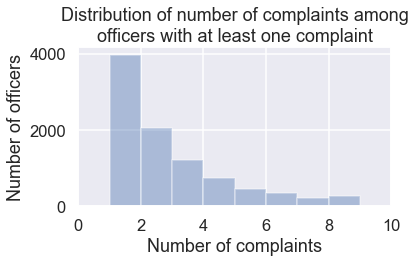

In [284]:
sns.distplot(counts, bins=np.arange(10), kde=False)
plt.xlim(0, 10)
plt.xlabel('Number of complaints')
plt.ylabel('Number of officers')
plt.title('Distribution of number of complaints among\n'
          'officers with at least one complaint');
plt.tight_layout()

plt.savefig('output/complaint_dist.png')

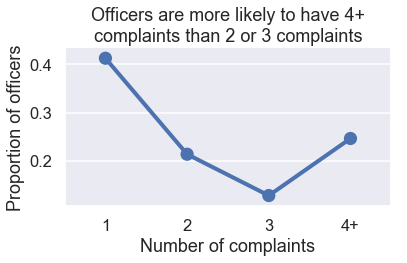

In [306]:
binned = pd.cut(counts, [1, 2, 3, 4, 999], right=False,
                labels=['1', '2', '3', '4+'])

sns.pointplot(
    data=pd.DataFrame({
        'complaints': binned,
        'proportion': 1 / len(binned),
    }),
    x='complaints', y='proportion', estimator=np.sum,
    order=['1', '2', '3', '4+'],
)

plt.xlabel('Number of complaints')
plt.ylabel('Proportion of officers')
plt.title('Officers are more likely to have 4+\n'
          'complaints than 2 or 3 complaints');
plt.tight_layout()

plt.savefig('output/complaint_counts.png')

In [174]:
(binned.value_counts() / len(binned)).sort_index()

1     0.41
2     0.21
3     0.13
4+    0.25
dtype: float64

In [201]:
past_three_years = (
    joined[joined['complaint_date'].dt.year.isin([2011, 2012, 2013])]
    .groupby('UID')
    .size()
    .rename('n_complaints')
    .to_frame()
)

past_three_years

,n_complaints
UID,
100007,5
100011,4
100012,1
...,...
132434,2
132446,1
133671,1


In [208]:
def proportion(arr):
    return np.count_nonzero(arr) / len(arr)

In [224]:
last_year = joined[joined['complaint_date'].dt.year.isin([2014, 2015])]

repeats = (past_three_years
 .merge(last_year, how='left', left_index=True, right_on='UID')
 .groupby('UID')
 [['n_complaints', 'cr_id']]
 .agg({'n_complaints': 'first', 'cr_id': np.any})
 .rename(columns={'cr_id': 'repeated'})
)

repeats

,n_complaints,repeated
UID,,
100007,5,True
100011,4,False
100012,1,False
...,...,...
132434,2,False
132446,1,False
133671,1,False


In [225]:
prop_repeat = (repeats
 .groupby('n_complaints')
 .agg([proportion, 'size'])
)

with pd.option_context('display.max_rows', 10):
    display(prop_repeat)

repeated      
             proportion  size
n_complaints                 
1                  0.14  1757
2                  0.21   463
3                  0.28   176
4                  0.38    71
5                  0.50    22
6                  0.42    12
7                  0.40     5
8                  0.50     2
9                  0.50     4
11                 1.00     1

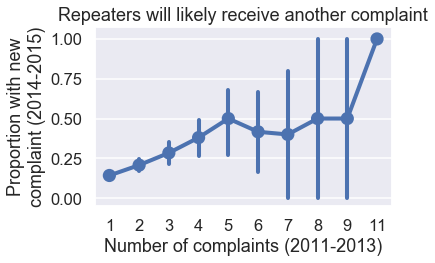

In [307]:
sns.pointplot(x='n_complaints', y='repeated', data=repeats)
plt.xlabel('Number of complaints (2011-2013)')
plt.ylabel('Proportion with new\n'
           'complaint (2014-2015)')
plt.title('Repeaters will likely receive another complaint')
plt.tight_layout()

plt.savefig('output/repeaters.png')

In [255]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=sys.maxsize)

def logit_coef(df):
    clf.fit(df[['n_complaints']], df['repeated'])
    return clf.coef_[0, 0]

observed = logit_coef(repeats)
observed

0.3740248512208941

In [308]:
def bootstrap_ci(df, test_statistic=logit_coef, ci=0.95, reps=10000):
    stats = [test_statistic(df.sample(frac=1, replace=True))
             for _ in t(range(reps))]
    return np.percentile(stats,
                         [(1 - ci) / 2 * 100, (ci + (1 - ci) / 2) * 100])

bootstrap_ci(repeats)

100%|██████████| 10000/10000 [00:45<00:00, 221.20it/s]


array([0.28, 0.47])